In [5]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler, StandardScaler # min/max scaling
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm
from MAPseq_processing import * # import all functions from this script
from MAPseq_plotting import * # import all functions from this script
import matplotlib.lines as mlines # needed for custom legend
from scipy import stats
import random

# for upset plots
from itertools import combinations, chain
from upsetplot import from_memberships
from math import comb
import upsetplot


# needed for editable text in svg format
plt.rcParams['svg.fonttype'] = 'none'

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'

#### load data
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin4.pkl")

#### load data
omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN4.pkl")



In [9]:

# initial processing
# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]
# seperate and concatenate by species
steg_it = []
steg_pt = []
mmus_it = []
mmus_pt = []

for i in range(metadata.shape[0]):
    if metadata.loc[i,"species"]=="STeg":
        steg_it.append(omc_it[i])
        steg_pt.append(omc_pt[i])
    elif metadata.loc[i,"species"]=="MMus":
        mmus_it.append(omc_it[i])
        mmus_pt.append(omc_pt[i])

st_it_all = pd.concat(steg_it)
st_pt_all = pd.concat(steg_pt)
mm_it_all = pd.concat(mmus_it)
mm_pt_all = pd.concat(mmus_pt)

# Functions

# Upset barplots w/ mean/std

In [ ]:
# plot_it = ["OMCc", "AUD", "STR"]

# # plot steg
# fancy_upsetplot(st_it_all, plot_it, reps=500, title="STeg IT Neurons", ymax=0.8)
# # plt.savefig(out_path+"st_it_upset.jpg", dpi=300)
# plt.show()


# fancy_upsetplot(st_it_all, plot_it, reps=500, subset="AUD", title="STeg IT Neurons", ymax=0.2)
# plt.savefig(out_path+"st_it_aud_upset.svg", dpi=300, bbox_inches="tight")
# plt.show()

# # plot mmus
# fancy_upsetplot(mm_it_all, plot_it, reps=250, color="tab:blue", title="MMus IT Neurons", ymax=0.8)
# # plt.savefig(out_path+"mm_it_upset.jpg", dpi=300, bbox_inches="tight")
# plt.show()

# fancy_upsetplot(mm_it_all, plot_it, reps=250, subset="AUD", color="tab:blue", title="MMus IT Neurons", ymax=0.2)
# plt.savefig(out_path+"mm_it_aud_upset.svg", dpi=300, bbox_inches="tight")
# plt.show()


In [ ]:
plot_it = ["OMCc", "AUD", "STR"]
st_it_aud = st_it_all[st_it_all["AUD"]==1]
mm_it_aud = mm_it_all[mm_it_all["AUD"]==1]


# steg
fancy_upsetplot(st_it_aud, plot_it, reps=500, subset="AUD", title="STeg AUD/IT Neurons", ymax=1,
                plot_legend=False, plot_sim=False)
plt.savefig(out_path+"st_it_aud_upset.svg", dpi=300, bbox_inches="tight")
plt.show()

# mmus
fancy_upsetplot(mm_it_aud, plot_it, reps=250, subset="AUD", color="tab:blue", title="MMus AUD/IT Neurons", ymax=1,
                plot_legend=False, plot_sim=False)
plt.savefig(out_path+"mm_it_aud_upset.svg", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# create stackd bar charts of relative proportions of motifs
# generate proportions for motifs (counts encounter problems in figure size???)
st_motif_prop = df_to_motif_proportion(st_it_aud, plot_it, proportion=True)
mm_motif_prop = df_to_motif_proportion(mm_it_aud, plot_it, proportion=True)

aud_prop = pd.DataFrame()
aud_prop["MMus"] = mm_motif_prop
aud_prop["STeg"] = st_motif_prop
aud_prop[(aud_prop.sum(axis=1)!=0)]

aud_prop = aud_prop.reset_index()


In [ ]:
aud = [l*"AUD" for l in aud_prop["AUD"]]
omcc = [l*"OMCc" for l in aud_prop["OMCc"]]
stri = [l*"STR" for l in aud_prop["STR"]]

motifs = []
for i in range(aud_prop.shape[0]):
    motif = aud[i]+"_"+omcc[i]+"_"+stri[i]
    motifs.append(motif)

aud_prop["motif"] = motifs

aud_prop = aud_prop.drop(["AUD", "OMCc", "STR"], axis=1)

plot_df = pd.melt(aud_prop, id_vars="motif", value_vars=["MMus", "STeg"], var_name="species", value_name="proportion")

In [ ]:
aud_prop
plot_df = pd.DataFrame(columns=aud_prop['motif'], index=["MMus", "STeg"])
plot_df.loc["MMus",:] = aud_prop["MMus"].values
plot_df.loc["STeg",:] = aud_prop["STeg"].values
plot_df

In [ ]:
plot_df.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.05,1))
plt.rcParams.update({'font.size': 12})
fig = plt.gcf()
fig.set_size_inches((2,4))
plt.ylabel("AUD Motif proportion")
plt.title("AUD Motif proportions", size=20, pad=20)
plt.savefig(out_path+"AUD_stacked.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from random import randrange
randrange(-5,5)/100

In [ ]:
motifs, st_simulations = motif_simulation(st_it_aud, plot_areas=plot_it, reps=500)
motifs, mm_simulations = motif_simulation(mm_it_aud, plot_areas=plot_it, reps=500)

In [ ]:
st_means = st_simulations.mean(axis=0)
mm_means = mm_simulations.mean(axis=0)
st_std = st_simulations.std(axis=0)
mm_std = mm_simulations.std(axis=0)
scatter_df = aud_prop.copy()
scatter_df["mm_means"] = mm_means
scatter_df["st_means"] = st_means
scatter_df["mm_std"] = mm_std
scatter_df["st_std"] = st_std
scatter_df

In [ ]:
aud_prop

plt.scatter(aud_prop["MMus"], aud_prop["STeg"])
# plt.scatter(scatter_df["mm_means"], scatter_df["st_means"])
# plt.errorbar(scatter_df['mm_means'], scatter_df['st_means'], 
#         xerr=scatter_df["mm_std"], fmt='|', color="black")
# plt.errorbar(scatter_df['mm_means'], scatter_df['st_means'], 
#         yerr=scatter_df["st_std"], fmt='|', color="black")
plt.axline((0,0), (0.9,0.9), color="grey", linestyle="--")
for i in range(aud_prop.shape[0]):
    jit = randrange(-5,5)/100
    plt.text(aud_prop.loc[i,"MMus"], aud_prop.loc[i,"STeg"]+jit, s=aud_prop.loc[i,"motif"], size=8)

plt.savefig(out_path+"AUD_motif_scatter.jpeg", dpi=300, bbox_inches="tight")
plt.show()

## pt cells motifs upset plot

In [4]:
plot_pt = ["BS", "SNr", "SCm", "PG", "HY", "PAG"]


# plot steg
# fancy_upsetplot(st_pt_all, plot_pt, reps=250, title="STeg PT Neurons", ymax=0.1, plot_legend=False)
# plt.show()

fancy_upsetplot(st_pt_all, plot_pt, reps=250, subset="PAG", title="STeg PT Neurons", ymax=0.1, plot_legend=False)
# plt.savefig(out_path+"st_pt_upset.jpg", dpi=300, bbox_inches="tight")
plt.show()

# plot mmus
# fancy_upsetplot(mm_pt_all, plot_pt, reps=250, color="tab:blue", title="MMus PT Neurons", ymax=0.1, plot_legend=False)
# plt.show()

fancy_upsetplot(mm_pt_all, plot_pt, reps=250, subset="PAG", color="tab:blue", title="MMus PT Neurons", ymax=0.1, plot_legend=False)
# plt.savefig(out_path+"mm_pt_upset.jpg", dpi=300, bbox_inches="tight")
plt.show()



NameError: name 'st_pt_all' is not defined

# modified upset plots
- plot grey bar for ci95 - emperically determined
- dot for real/observed proportion
- calc emperic p-value

## IT Cells

In [ ]:
to_plot = ["OMCc", "AUD", "STR"]
motifs, simulations = motif_simulation(st_it_all, plot_areas=to_plot)
motif_prop = df_to_motif_proportion(st_it_all, areas=to_plot)

print(motif_prop)


In [ ]:
to_plot = ["OMCc", "AUD", "STR"]

plot_motif_hist_prop(st_it_all, title="STeg IT Motifs", reps=1000)
plt.show()

plot_motif_hist_prop(mm_it_all, title="MMus IT Motifs", color="tab:blue", reps=1000)
plt.show()

## PT cells

In [ ]:
plot_pt = ["BS", "SNr", "SCm", "PG", "HY", "PAG"]
motifs, simulations = motif_simulation(st_pt_all, plot_areas=plot_pt, subset="PAG")
motif_prop = df_to_motif_proportion(st_pt_all, areas=plot_pt, subset="PAG")
motif_prop

In [ ]:
# plot simulated motif histograms w/ line for real value
plot_pt = ["BS", "SNr", "SCm", "PG", "HY", "PAG"]

plot_motif_hist_prop(st_pt_all, title="STeg PAG/PT Motifs", plot_areas=plot_pt,
                      subset_area="PAG", subset_idx=(16,32), reps=500)
plt.show()

plot_motif_hist_prop(mm_pt_all, title="MMus PAG/PT Motifs", color="tab:blue", 
                     subset_area="PAG", plot_areas=plot_pt, subset_idx=(16,32), reps=500)
plt.show()

# PT clean-up
- PAG+1, PAG+2, PAG+3...

In [10]:
# motifs, simulatioms
plot_pt = ["BS", "SNr", "SCm", "PG", "HY", "PAG"]



# generate motif counts
pag_count = df_to_motif_proportion(st_pt_all, plot_pt, proportion=False, subset="PAG")

pag_index = np.array(pag_count.index.tolist())

degree = pag_index.sum(axis=1)


# pag_df = pd.DataFrame(columns=["PAG", "PAG+1", "PAG+2", "PAG+3", "PAG+4", "PAG+5", "PAG+6(all)"])

st_count =  []
for i in range(1,7):
    idx = [j for j in range(pag_index.shape[0]) if degree[j]==i]
    st_count.append(pag_count[idx].sum())

st_prop = [c/st_pt_all.shape[0] for c in st_count]

print(st_count)
print(st_prop)


[12, 34, 69, 140, 147, 30]
[0.012232415902140673, 0.034658511722731905, 0.07033639143730887, 0.14271151885830785, 0.14984709480122324, 0.03058103975535168]


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_s = plot_s[idx]
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_20185/1539931784.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  st_count.append(pag_count[idx].sum())


In [11]:
# motifs, simulatioms

# generate motif counts
pag_count = df_to_motif_proportion(mm_pt_all, plot_pt, proportion=False, subset="PAG")

pag_index = np.array(pag_count.index.tolist())

degree = pag_index.sum(axis=1)


# pag_df = pd.DataFrame(columns=["PAG", "PAG+1", "PAG+2", "PAG+3", "PAG+4", "PAG+5", "PAG+6(all)"])

mm_count =  []
for i in range(1,7):
    idx = [j for j in range(pag_index.shape[0]) if degree[j]==i]
    mm_count.append(pag_count[idx].sum())

mm_prop = [c/mm_pt_all.shape[0] for c in mm_count]

print(mm_count)
print(mm_prop)


[17, 55, 192, 442, 662, 122]
[0.0018360514094394643, 0.0059401663246570905, 0.02073658062425748, 0.04773733664542607, 0.07149800194405444, 0.013176368938330274]


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:470: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_s = plot_s[idx]
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_20185/1254945671.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mm_count.append(pag_count[idx].sum())


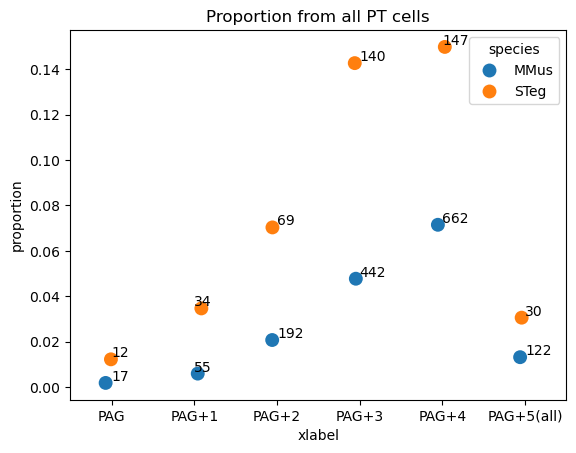

In [12]:
xlabels = ["PAG", "PAG+1", "PAG+2", "PAG+3", "PAG+4", "PAG+5(all)"]

st_df = pd.DataFrame({"xlabel":xlabels, "proportion":st_prop, "count":st_count, "species":"STeg"})
mm_df = pd.DataFrame({"xlabel":xlabels, "proportion":mm_prop, "count":mm_count, "species":"MMus"})
plot_df = pd.concat([mm_df, st_df]).reset_index(drop=True)


sns.stripplot(plot_df, x="xlabel", y="proportion", hue="species",
              size=10)
# annotate w/ count
for i in range(plot_df.shape[0]):
    plt.text(plot_df.loc[i,"xlabel"], plot_df.loc[i,"proportion"]+0.001,
             s=str(plot_df.loc[i,"count"]))
    
plt.title("Proportion from all PT cells")
plt.show()

In [13]:
# calculate proportion via all PAG not all PT cells
mm_pag = plot_df[plot_df["species"]=="MMus"]
mm_pag_tot = mm_pag["count"].sum()
st_pag = plot_df[plot_df["species"]=="STeg"]
st_pag_tot = st_pag["count"].sum()

for i in range(plot_df.shape[0]):
    if plot_df.loc[i, "species"]=="MMus":
        plot_df.loc[i,"pag_prop"] = plot_df.loc[i,"count"]/mm_pag_tot
    elif plot_df.loc[i,"species"]=="STeg":
        plot_df.loc[i,"pag_prop"] = plot_df.loc[i,"count"]/st_pag_tot

plot_df

,xlabel,proportion,count,species,pag_prop
0,PAG,0.001836,17,MMus,0.011409
1,PAG+1,0.005940,55,MMus,0.036913
2,PAG+2,0.020737,192,MMus,0.128859
3,PAG+3,0.047737,442,MMus,0.296644
4,PAG+4,0.071498,662,MMus,0.444295
5,PAG+5(all),0.013176,122,MMus,0.081879
6,PAG,0.012232,12,STeg,0.027778
7,PAG+1,0.034659,34,STeg,0.078704
8,PAG+2,0.070336,69,STeg,0.159722
9,PAG+3,0.142712,140,STeg,0.324074


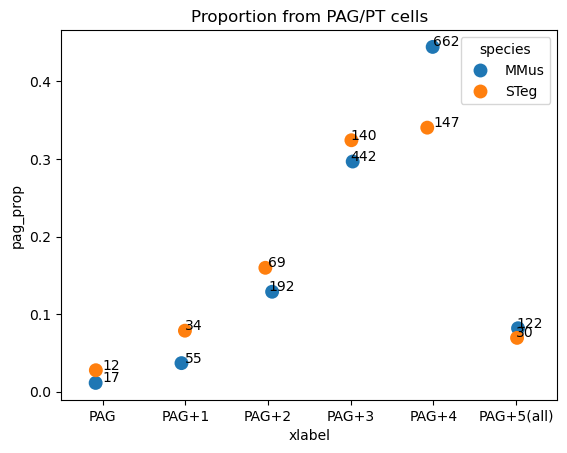

In [14]:
sns.stripplot(plot_df, x="xlabel", y="pag_prop", hue="species",
              size=10)
# annotate w/ count
for i in range(plot_df.shape[0]):
    plt.text(plot_df.loc[i,"xlabel"], plot_df.loc[i,"pag_prop"]+0.001,
             s=str(plot_df.loc[i,"count"]))
    
plt.title("Proportion from PAG/PT cells")
plt.show()

In [15]:
include = [["PAG"],
           ["PAG", "+1"],
           ["PAG", "+1", "+2"],
           ["PAG", "+1", "+2", "+3"],
           ["PAG", "+1", "+2", "+3", "+4"],
           ["PAG", "+1", "+2", "+3", "+4", "+5"]]

mm_counts = plot_df[0:6]["count"]

# calculate sum just w/in PAG group
mm_prop = plot_df[0:6]["count"]/plot_df[0:6]["count"].sum()


plot_s = from_memberships(include, data=mm_prop)
# plot_s = from_memberships(include, data=plot_df[0:6]["proportion"])
plot_s

+1     +2     +3     +4     +5     PAG 
False  False  False  False  False  True    0.011409
True   False  False  False  False  True    0.036913
       True   False  False  False  True    0.128859
              True   False  False  True    0.296644
                     True   False  True    0.444295
                            True   True    0.081879
Name: count, dtype: float64

In [16]:


# # generate motif counts
# pag_count = df_to_motif_proportion(mm_pt_all, plot_pt, proportion=False, subset="PAG")

# pag_index = np.array(pag_count.index.tolist())

# degree = pag_index.sum(axis=1)


# # pag_df = pd.DataFrame(columns=["PAG", "PAG+1", "PAG+2", "PAG+3", "PAG+4", "PAG+5", "PAG+6(all)"])

# mm_count =  []
# for i in range(1,7):
#     idx = [j for j in range(pag_index.shape[0]) if degree[j]==i]
#     mm_count.append(pag_count[idx].sum())

# mm_prop = [c/mm_pt_all.shape[0] for c in mm_count]

# print(mm_count)
# print(mm_prop)

In [17]:
plot_df

,xlabel,proportion,count,species,pag_prop
0,PAG,0.001836,17,MMus,0.011409
1,PAG+1,0.005940,55,MMus,0.036913
2,PAG+2,0.020737,192,MMus,0.128859
3,PAG+3,0.047737,442,MMus,0.296644
4,PAG+4,0.071498,662,MMus,0.444295
5,PAG+5(all),0.013176,122,MMus,0.081879
6,PAG,0.012232,12,STeg,0.027778
7,PAG+1,0.034659,34,STeg,0.078704
8,PAG+2,0.070336,69,STeg,0.159722
9,PAG+3,0.142712,140,STeg,0.324074


/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['tab:blue' '#1f77b42e' '#1f77b42e' '#1f77b42e' '#1f77b42e' '#1f77b42e'
 'tab:blue' 'tab:blue' '#1f77b42e' '#1f77b42e' '#1f77b42e' '#1f77b42e'
 'tab:blue' 'tab:blue' 'tab:blue' '#1f77b42e' '#1f77b42e' '#1f77b42e'
 'tab:blue' 'tab:blue' 'tab:blue' 'tab:blue' '#1f77b42e' '#1f77b42e'
 'tab:blue' 'tab:blue' 'tab:blue' 'tab:blue' 'tab:blue' '#1f77b42e'
 'tab:blue' 'tab:blue' 'tab:blue' 'tab:blue' 'tab:blue' 'tab:blue']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. V

1490


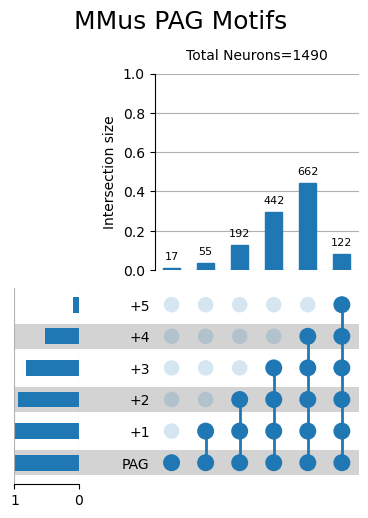

In [19]:
include = [["PAG"],
           ["PAG", "+1"],
           ["PAG", "+1", "+2"],
           ["PAG", "+1", "+2", "+3"],
           ["PAG", "+1", "+2", "+3", "+4"],
           ["PAG", "+1", "+2", "+3", "+4", "+5"]]

mm_counts = plot_df[0:6]["count"]

# calculate sum just w/in PAG group
mm_prop = plot_df[0:6]["count"]/plot_df[0:6]["count"].sum()


plot_s = from_memberships(include, data=mm_prop)
# plot_s = from_memberships(include, data=plot_df[0:6]["proportion"])
plot_s

upsetplot.plot(plot_s, facecolor="tab:blue", shading_color="lightgrey", with_lines=True)
print(str(mm_counts.sum()))

plt.title("Total Neurons="+str(mm_counts.sum()), pad=10, fontsize=10)
plt.suptitle("MMus PAG Motifs", y=1, fontsize=18)

x = list(range(plot_s.shape[0]))

for i in x:
    plt.text(x=i, y=plot_s[i]+0.04, s=str(mm_counts[i]), ha="center", fontsize=8, zorder=12)
plt.ylim(0, 1)
plt.savefig(out_path+"mmus_pag_upset.svg", dpi=300, bbox_inches="tight")
plt.show()

/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['tab:orange' '#ff7f0e2e' '#ff7f0e2e' '#ff7f0e2e' '#ff7f0e2e' '#ff7f0e2e'
 'tab:orange' 'tab:orange' '#ff7f0e2e' '#ff7f0e2e' '#ff7f0e2e' '#ff7f0e2e'
 'tab:orange' 'tab:orange' 'tab:orange' '#ff7f0e2e' '#ff7f0e2e'
 '#ff7f0e2e' 'tab:orange' 'tab:orange' 'tab:orange' 'tab:orange'
 '#ff7f0e2e' '#ff7f0e2e' 'tab:orange' 'tab:orange' 'tab:orange'
 'tab:orange' 'tab:orange' '#ff7f0e2e' 'tab:orange' 'tab:orange'
 'tab:orange' 'tab:orange' 'tab:orange' 'tab:orange']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/Users/eisko/mambaforge/envs/MAPseq_231109/lib/python3.12/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated an

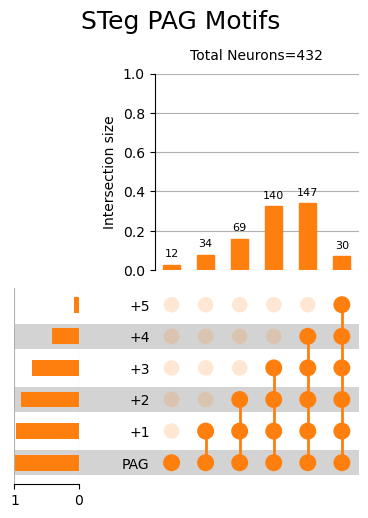

In [21]:
include = [["PAG"],
           ["PAG", "+1"],
           ["PAG", "+1", "+2"],
           ["PAG", "+1", "+2", "+3"],
           ["PAG", "+1", "+2", "+3", "+4"],
           ["PAG", "+1", "+2", "+3", "+4", "+5"]]

st_counts = plot_df[6:12]["count"].reset_index(drop=True)

# calculate sum just w/in PAG group
st_prop = plot_df[6:12]["count"]/plot_df[6:12]["count"].sum()


plot_s = from_memberships(include, data=st_prop)
# plot_s = from_memberships(include, data=plot_df[0:6]["proportion"])


upsetplot.plot(plot_s, facecolor="tab:orange", shading_color="lightgrey", with_lines=True)
plt.title("Total Neurons="+str(st_counts.sum()), pad=10, fontsize=10)
plt.suptitle("STeg PAG Motifs", y=1, fontsize=18)

x = list(range(plot_s.shape[0]))

for i in x:
    plt.text(x=i, y=plot_s[i]+0.04, s=str(st_counts[i]), ha="center", fontsize=8, zorder=12)
plt.ylim(0, 1)
plt.savefig(out_path+"steg_pag_upset.svg", dpi=300, bbox_inches="tight")
plt.show()

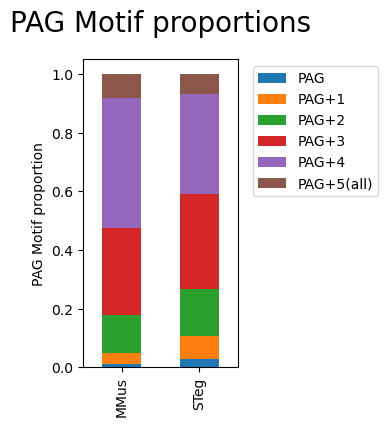

In [22]:
plot_df["PAG_proportions"] = np.concatenate([mm_prop, st_prop])
plot_stack = pd.DataFrame(index=["MMus", "STeg"], columns=plot_df.loc[0:5,'xlabel'])
plot_stack.loc["MMus",:] = plot_df.loc[0:5, "PAG_proportions"].values
plot_stack.loc["STeg",:] = plot_df.loc[6:11, "PAG_proportions"].values
plot_stack
# stacked bar charts
# create stackd bar charts of relative proportions of motifs
# generate proportions for motifs (counts encounter problems in figure size???)


plot_stack.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.05,1))
plt.rcParams.update({'font.size': 12})
fig = plt.gcf()
fig.set_size_inches((2,4))
plt.ylabel("PAG Motif proportion")
plt.title("PAG Motif proportions", size=20, pad=20)
plt.savefig(out_path+"PAG_stacked.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(degree)
plt.title("Degree distribution for PAG/PT cells")

# Add PAB to histogram plots

## IT Cells

In [ ]:
# mm_it_prop = df_to_motif_proportion(mm_it_all, areas=plot_it, proportion=True)
# mm_it_pab = df_to_calc_pab_proportions(mm_it_all, mm_it_prop.index)

st_it_prop = df_to_motif_proportion(st_it_all, areas=plot_it, proportion=True)
st_it_pab = df_to_calc_pab_proportions(st_it_all, st_it_prop.index)

In [ ]:
to_plot = ["OMCc", "AUD", "STR"]

plot_motif_hist_prop(st_it_all, title="STeg IT Motifs", reps=1000, plot_pab=True)
plt.show()

plot_motif_hist_prop(mm_it_all, title="MMus IT Motifs", color="tab:blue", reps=1000, plot_pab=True)
plt.show()

## obs vs calc motif proportions

mm_motif_prop = df_to_motif_proportion(mm_it_all, areas=plot_it, proportion=True)
mm_motif_calc_prop = df_to_calc_pab_proportions(mm_it_all, mm_motif_prop.index)
st_motif_prop = df_to_motif_proportion(st_it_all, areas=plot_it, proportion=True)
st_motif_calc_prop = df_to_calc_pab_proportions(st_it_all, st_motif_prop.index)

plt.scatter(mm_motif_prop, mm_motif_calc_prop, label="MMus")
plt.scatter(st_motif_prop, st_motif_calc_prop, label="STeg")
plt.xlabel("Observed motif proportion")
plt.ylabel("Calculated P(A)*P(B)")
plt.title("IT cells motif proporitons obs vs. calc")
plt.axline((0,0), (0.08,0.08), color="grey", linestyle="--")
plt.show()


## PT Cells

In [ ]:
# plot simulated motif histograms w/ line for real value
plot_pt = ["BS", "SNr", "SCm", "PG", "HY", "PAG"]

plot_motif_hist_prop(st_pt_all, title="STeg PAG/PT Motifs", plot_areas=plot_pt,
                      subset_area="PAG", subset_idx=(16,32), reps=500, plot_pab=True)
plt.show()

plot_motif_hist_prop(mm_pt_all, title="MMus PAG/PT Motifs", color="tab:blue", 
                     subset_area="PAG", plot_areas=plot_pt, subset_idx=(16,32), 
                     reps=500, plot_pab=True)
plt.show()

In [ ]:
# pt cells plot

mm_motif_prop = df_to_motif_proportion(mm_pt_all, areas=plot_pt, proportion=True, subset="PAG")
mm_motif_calc_prop = df_to_calc_pab_proportions(mm_pt_all, mm_motif_prop.index)
st_motif_prop = df_to_motif_proportion(st_pt_all, areas=plot_pt, proportion=True, subset="PAG")
st_motif_calc_prop = df_to_calc_pab_proportions(st_pt_all, st_motif_prop.index)

plt.scatter(mm_motif_prop[16:32], mm_motif_calc_prop[16:32], label="MMus")
plt.scatter(st_motif_prop[16:32], st_motif_calc_prop[16:32], label="STeg")
plt.xlabel("Observed motif proportion")
plt.ylabel("Calculated P(A)*P(B)")
plt.title("PT cells motif proporitons obs vs. calc")
plt.axline((0,0), (0.08,0.08), color="grey", linestyle="--")
plt.show()

# 